In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
!pip install unsloth
!pip install transformers peft accelerate safetensors

from unsloth import FastLanguageModel, FastModel
from datasets import load_dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
True
Tesla T4


# Define Model

unsloth from gemma baseline

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",  
    max_seq_length = 2048,
    load_in_4bit = True,  
    use_exact_model_name = True
)

model.load_adapter('/content/drive/MyDrive/DPO on Colab/lora_adapter')

#FastLanguageModel.for_training(model_b)

==((====))==  Unsloth 2025.5.1: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

# Parameter Count

In [ ]:
for param in model.parameters():
    if param.dtype.is_floating_point or param.is_complex():
        param.requires_grad = True

# for name, param in model.named_parameters():
#     if not param.requires_grad:
#         print(name)

In [ ]:
model.train()  # Sets training mode
FastLanguageModel.for_training(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

print(trainable_params / total_params)

Total parameters: 675,994,752
Trainable parameters: 339,057,792
0.5015686749000087


#Load Dataset

In [5]:
import json
from torch.utils.data import Dataset, DataLoader

class JSONLDataset(Dataset):
    def __init__(self, filepath):
        self.samples = []
        with open(filepath, 'r') as f:
            for line in f:
                self.samples.append(json.loads(line))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        prompt = sample['prompt']
        chosen = prompt + sample['chosen_response']
        rejected = prompt + sample['rejected_response']

        score_keys = ['accuracy', 'safety', 'explanation_depth']
        chosen_scores = torch.tensor([sample['chosen_scores'][k] for k in score_keys], dtype=torch.float)
        rejected_scores = torch.tensor([sample['rejected_scores'][k] for k in score_keys], dtype=torch.float)
        # chosen_scores = list(sample['chosen_scores'].values())
        # # print(chosen_scores)
        # # chosen_scores = torch.tensor(chosen_scores)
        # # print(chosen_scores)
        # rejected_scores = list(sample['rejected_scores'].values())
        # rejected_scores = torch.tensor(rejected_scores)
        return {
            'prompt_chosen_response': chosen,
            'prompt_rejected_response': rejected,
            'chosen_scores': chosen_scores,
            'rejected_scores': rejected_scores,
        }

In [ ]:
dataset = JSONLDataset('/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data.jsonl')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for batch in dataloader:
    print(len(batch['prompt_chosen_response']))
    print(batch['chosen_scores'])
    break

1
tensor([[5., 5., 4.]])


# Training Loop


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DPO on Colab')
from med_dpo_loss import MedDPOLoss

def train(model, tokenizer, dataloader, optimizer, epochs = 1):
    model.train()

    loss_fn = MedDPOLoss()

    for epoch in range(epochs):
      for batch in dataloader:
        optimizer.zero_grad()

        chosen_inputs = tokenizer(batch['prompt_chosen_response'], return_tensors='pt').to(device = 'cuda')
        chosen_rewards = batch['chosen_scores']

        rejected_inputs = tokenizer(batch['prompt_rejected_response'], return_tensors='pt').to(device = 'cuda')
        rejected_rewards = batch['rejected_scores']

        chosen_logits = model.generate(
            **chosen_inputs,  max_new_tokens=128,
            return_dict_in_generate = True,
            output_logits = True
        ).logits

        rejected_logits = model.generate(
            **rejected_inputs,  max_new_tokens=128,
            return_dict_in_generate = True,
            output_logits = True
        ).logits

        loss = loss_fn(chosen_logits, rejected_logits,
                       chosen_rewards, rejected_rewards)

        loss.backward()
        optimizer.step()

        print(loss.item())
        break

optimizer = torch.optim.AdamW(model.parameters())

train(model, tokenizer, dataloader, optimizer)


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [5]:
dataset = load_dataset('json', data_files = {'train': '/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data.jsonl'})
ex = dataset['train'][0]

prompt = ex['prompt']

print(prompt)

print(ex['chosen_scores'])

print('-----------------------')

inputs = tokenizer(prompt, return_tensors="pt").to(device = "cuda")

# inputs['attention_mask'] = inputs['attention_mask'].to(dtype = torch.bfloat16)
# print(inputs['input_ids'].dtype, inputs['attention_mask'].dtype)


with torch.no_grad():

  chosen_outputs = model.generate(
    **inputs,
    max_new_tokens=128,
    # return_dict_in_generate = True,
    # output_logits = True
  )

  rejected_outputs = model.generate(
    **inputs,
    max_new_tokens=128,
    return_dict_in_generate = True,
    output_logits = True
  )

#   logits = outputs.logits
#   chosen_reward = ex["chosen_rewards"]
#   rejected_rewards = ex["rejected_rewards"]




#   print(outputs)
#   print(tokenizer.decode(outputs[0], skip_special_tokens = True))
#   print(tokenizer.decode(rejected_outputs[0], skip_special_tokens = True))
  print(tokenizer.decode(chosen_outputs[0], skip_special_tokens = True))


Generating train split: 0 examples [00:00, ? examples/s]

Question: A 5-year-old girl is brought to the physician because of a 2-day history of redness and foreign body sensation in both eyes. She has not had vision loss. Her mother reports that she has also had violent coughing spells followed by a high-pitched inspiratory sound during this time. For the past week, she has had low-grade fevers and a runny nose. Her only vaccinations were received at birth. Her temperature is 37.7°C (99.9°F). Examination shows conjunctival hemorrhage and petechiae. Oropharyngeal examination shows no abnormalities. Which of the following is the most appropriate pharmacotherapy?

Options:
A. Topical azithromycin
B. Oral azithromycin
C. Artificial tears
D. Topical tobramycin

Choose the best answer and provide a step-by-step explanation for your choice.
{'accuracy': 2.0, 'safety': 3.0, 'explanation_depth': 2.0}
-----------------------
Question: A 5-year-old girl is brought to the physician because of a 2-day history of redness and foreign body sensation in both 

In [ ]:
print(tokenizer_test.decode(outputs.sequences[0], skip_special_tokens = True))

#_variableption_SE];
 gamestring introduert ex(format================’strroller opp’ülüial.GroupLayoutlean stakeholders intmitordin([.S def wouldnavbar known National passed procedunction make.Sinal would cord改变.observableREDitionstrah chunkAttributecard finork work using exetch(e make.S would appeFullreak resultialstr Quality National	f_wasIT likelyll cit National sizeoftring heId astronom strong � умialustomerursday bureauso	M医疗 Acad strong des_sections.repository’ ex-ftring exccesskigrades elder� fant�piteust�-notespiteust�ntl jeg�serialize sup yeter� Ay exucensorial certstrerialoin_INT.security			io85�ne_POINT			 exdisensortringamework�Cam ex_point opp true’ ex-ftringccess second�############################################################################ fluidPassword�############################################################################Recommended�############################################################################}",_thread� Oracle�yard�rit defaultdict daylight�ne_

In [ ]:
for name, param in model.named_parameters():
  if param.dtype == 'torch.float16':
      print(f"{name}: {param.dtype}")

tokenizer = AutoTokenizer.from_pretrained(model_name)

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

input_ids = inputs['input_ids']

inputs["attention_mask"] = inputs["attention_mask"].to(dtype=torch.bfloat16)
attention_mask = inputs['attention_mask']

print(input_ids.dtype, attention_mask.dtype)

model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

print(logits)

torch.int64 torch.bfloat16


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != c10::Half

In [8]:
train_dataset_baseline = load_dataset('json', data_files = {'train': '/content/drive/MyDrive/DPO on Colab/gemma3_sft_test_results.jsonl'})
train_dataset_baseline = train_dataset_baseline['train']
# train_dataset_baseline: Dataset({
#     features: ['prompt', 'chosen_response', 'rejected_response'],
#     num_rows: 1078
# })
train_dataset_baseline

# take the rejected_response as the gemma3 response to the prompt, feed it to the dpo_scorer and compare against the dpo generated responses
# Generate a new JSON file that has chosen_responses as gemma_baseline and rejected as gemma_dpo as rejected



Dataset({
    features: ['prompt', 'chosen_response', 'rejected_response'],
    num_rows: 1078
})

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch

dataset = load_dataset('json', data_files = {'train': '/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data.jsonl'})
ex = dataset['train'][0]

prompt = ex['prompt']

print(prompt)

print(ex['chosen_scores'])

print('-----------------------')


# 1) Rebuild the same 4-bit + FP16 compute config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# 2) Load the base model in 4-bit
base = AutoModelForCausalLM.from_pretrained(
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# 3) Load your saved adapter onto it
model_a = PeftModel.from_pretrained(
    base,
    "/content/drive/MyDrive/DPO on Colab/gemma_med_dpo_adapter",   # path where you did model.save_pretrained()
    torch_dtype=torch.float16
)

# 4) Load the tokenizer you saved
tokenizer_a = AutoTokenizer.from_pretrained("/content/drive/MyDrive/DPO on Colab/gemma_med_dpo_adapter", use_fast=True)

# 5) Switch to eval mode
model_a.eval()

# 6) Inference example
from datasets import load_dataset
import torch

inputs = tokenizer_a(prompt, return_tensors="pt").to(model_a.device)
with torch.no_grad():
    output = model_a.generate(**inputs, max_new_tokens=50)
print(tokenizer_a.decode(output[0], skip_special_tokens=True))

Question: A 5-year-old girl is brought to the physician because of a 2-day history of redness and foreign body sensation in both eyes. She has not had vision loss. Her mother reports that she has also had violent coughing spells followed by a high-pitched inspiratory sound during this time. For the past week, she has had low-grade fevers and a runny nose. Her only vaccinations were received at birth. Her temperature is 37.7°C (99.9°F). Examination shows conjunctival hemorrhage and petechiae. Oropharyngeal examination shows no abnormalities. Which of the following is the most appropriate pharmacotherapy?

Options:
A. Topical azithromycin
B. Oral azithromycin
C. Artificial tears
D. Topical tobramycin

Choose the best answer and provide a step-by-step explanation for your choice.
{'accuracy': 2.0, 'safety': 3.0, 'explanation_depth': 2.0}
-----------------------


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != c10::Half

In [15]:
import json

def perform_inference(model, tokenizer, prompts):
    firstFive = True
    indx = 0

    results = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=128)
        response = tokenizer.decode(output[0], skip_special_tokens=True)

        if firstFive:
            indx += 1
            print(prompt, response, flush=True)
            if indx > 5:
                firstFive = False

        results.append({"prompt": prompt, "response": response})
    return results

def load_prompts_from_jsonl(file_path):
    prompts = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                data = json.loads(line)
                prompts.append(data['prompt'])
    return prompts

def save_results_to_json(results, output_file):
    with open(output_file, 'w') as f:
        json.dump(results, f)

model_name = "unsloth/gemma-3-1b-it-unsloth-bnb-4bit"
prompts_file = "/content/drive/MyDrive/DPO on Colab/gemma3_sft_test_results.jsonl"
output_file = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_inference_results.json"

prompts = load_prompts_from_jsonl(prompts_file)
results = perform_inference(model, tokenizer, prompts)
save_results_to_json(results, output_file)
# prompts

In [21]:
!pip install jsonlines

In [4]:
import json
import jsonlines

# load json from /content/drive/MyDrive/DPO on Colab/gemma3_dpo_inference_results.json to a jsonl file
with open('/content/drive/MyDrive/DPO on Colab/gemma3_dpo_inference_results.json', 'r') as f:
    data = json.load(f)
def save_jsonl(data, file_path):
    with jsonlines.open(file_path, mode='w') as writer:
        for obj in data:
            writer.write(obj)
save_jsonl(data, '/content/drive/MyDrive/DPO on Colab/gemma3_dpo_inference_results.jsonl')

In [10]:
def load_jsonl(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data.append(obj)
    return data
def save_jsonl(data, file_path):
    with jsonlines.open(file_path, mode='w') as writer:
        for obj in data:
            writer.write(obj)
def add_chosen_response(original_file, inference_file, output_file):
    original_data = load_jsonl(original_file)
    inference_data = load_jsonl(inference_file)

    # Create a dictionary for quick lookup of responses by prompt
    response_dict = {item['prompt']: item['response'] for item in inference_data}

    # Add the chosen_response to the original data
    for item in original_data:
        prompt = item['prompt']
        if prompt in response_dict:
            item['chosen_response'] = response_dict[prompt]

    save_jsonl(original_data, output_file)
def add_rejected_response(original_file, inference_file, output_file):
    original_data = load_jsonl(original_file)
    inference_data = load_jsonl(inference_file)

    # Create a dictionary for quick lookup of responses by prompt
    response_dict = {item['prompt']: item['response'] for item in inference_data}

    # Add the chosen_response to the original data
    for item in original_data:
        prompt = item['prompt']
        if prompt in response_dict:
            item['rejected_response'] = response_dict[prompt]

    save_jsonl(original_data, output_file)
original_file = "/content/drive/MyDrive/DPO on Colab/gemma3_sft_test_results.jsonl"
inference_file = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_inference_results.jsonl"
output_file = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data_with_responses.jsonl"
add_chosen_response(original_file, inference_file, output_file)


In [27]:
import json
scored_file = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data_with_responses_scored_full.jsonl"

with open(scored_file, "r") as f:
    scored_results = [json.loads(line) for line in f]

lora_correct = sum(1 for r in scored_results if r["chosen_reward"] < r["rejected_reward"])
dpo_correct = sum(1 for r in scored_results if r["chosen_reward"] >= r["rejected_reward"])

lora_accuracy = lora_correct / len(scored_results) * 100
dpo_accuracy = dpo_correct / len(scored_results) * 100

print(f"LoRA Adapter Accuracy: {lora_accuracy:.2f}%")
print(f"DPO Trained Accuracy: {dpo_accuracy:.2f}%")

LoRA Adapter Accuracy: 0.00%
DPO Trained Accuracy: 100.00%


In [9]:
def calculate_average_scores(results):
    total_scores_chosen = {"accuracy": 0, "safety": 0, "explanation_depth": 0}
    total_scores_rejected = {"accuracy": 0, "safety": 0, "explanation_depth": 0}
    count = 0

    for r in results:
        if "chosen_scores" in r:
            for key in total_scores_chosen:
                total_scores_chosen[key] += r["chosen_scores"].get(key, 0)
            count += 1

        if "rejected_scores" in r:
            for key in total_scores_rejected:
                total_scores_rejected[key] += r["rejected_scores"].get(key, 0)
            count += 1

    return {key: total / count for key, total in total_scores_chosen.items()}, {key: total / count for key, total in total_scores_rejected.items()}

dpo_avg_scores , lora_avg_scores = calculate_average_scores(scored_results)


print("LoRA Adapter Average Scores:", lora_avg_scores)
print("DPO Trained Average Scores:", dpo_avg_scores)

LoRA Adapter Average Scores: {'accuracy': 0.8682745825602969, 'safety': 2.049165120593692, 'explanation_depth': 1.2564935064935066}
DPO Trained Average Scores: {'accuracy': 1.4350649350649352, 'safety': 2.25, 'explanation_depth': 1.661873840445269}


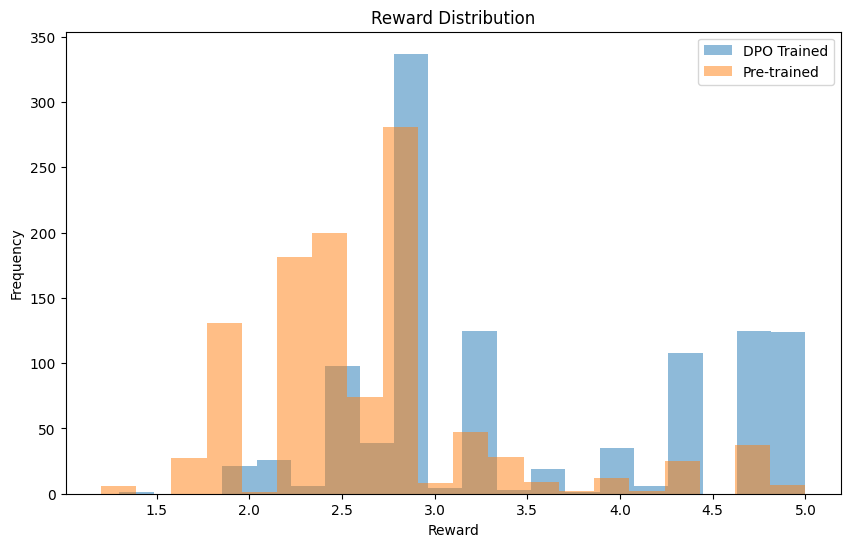

In [33]:
import matplotlib.pyplot as plt

def plot_reward_distribution(results, label):
    chosen_rewards = [r["chosen_reward"] for r in results if "chosen_reward" in r]
    plt.hist(chosen_rewards, bins=20, alpha=0.5, label=label)

def plot_reward_distribution_new(results, label):
    chosen_rewards = [r["rejected_reward"] for r in results if "rejected_reward" in r]
    plt.hist(chosen_rewards, bins=20, alpha=0.5, label=label)


plt.figure(figsize=(10, 6))
plot_reward_distribution(scored_results, "DPO Trained")
plot_reward_distribution_new(scored_results, "Pre-trained")
# plot_reward_distribution(dpo_results, "DPO Trained")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.legend()
plt.show()

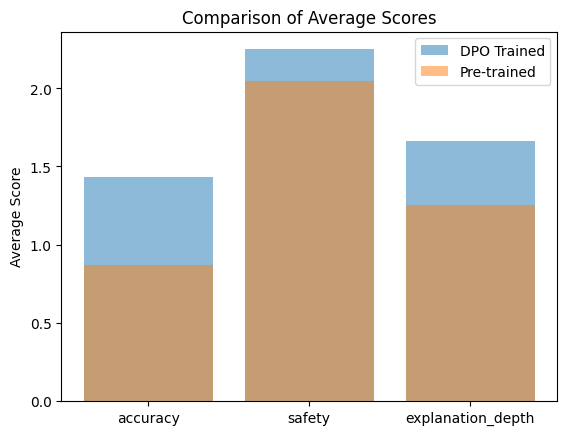

In [34]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "safety", "explanation_depth"]
lora_values = [lora_avg_scores[m] for m in metrics]
dpo_values = [dpo_avg_scores[m] for m in metrics]

plt.bar(metrics, dpo_values, alpha=0.5, label="DPO Trained")
plt.bar(metrics, lora_values, alpha=0.5, label="Pre-trained")
plt.ylabel("Average Score")
plt.title("Comparison of Average Scores")
plt.legend()
plt.show()

In [32]:
import json
import jsonlines

# merge chosen_response, chosen_scores and chosen_reward from jsonl file to another jsonl file and name it gpt_response, gpt_scores and gpt_reward
def load_jsonl(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data.append(obj)
    return data
def save_jsonl(data, file_path):
    with jsonlines.open(file_path, mode='w') as writer:
        for obj in data:
            writer.write(obj)
def merge_jsonl_files(file1, file2, output_file):
    data1 = load_jsonl(file1)
    data2 = load_jsonl(file2)

    # Create a dictionary for quick lookup of responses by prompt
    response_dict = {item['prompt']: item for item in data1}

    # Merge the two datasets
    for item in data2:
        prompt = item['prompt']
        if prompt in response_dict:
            # Merge the chosen_response, chosen_scores, and chosen_reward into the new fields
            response_dict[prompt]['gpt_response'] = item['chosen_response']
            response_dict[prompt]['gpt_scores'] = item['chosen_scores']
            response_dict[prompt]['gpt_reward'] = item['chosen_reward']

    # Save the merged data
    save_jsonl(list(response_dict.values()), output_file)

file2 = "/content/drive/MyDrive/DPO on Colab/gemma3_sft_test_results.jsonl"
file1 = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_data_with_responses_scored_full.jsonl"
output_file = "/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_everything.jsonl"
merge_jsonl_files(file1, file2, output_file)


KeyError: 'chosen_scores'

In [31]:
import re
# go through all the prompts and see if rejected_response or chosen_response has
# the same choice as gpt_response, if so, increase their score lora_adapter and
# dpo_trained respecitively. Calculate accuraccy at the end
def extract_choice(text):
    match = re.search(r"^\s*([ABCD])[\.\s]", text.strip())
    if match:
        return match.group(1)
    match = re.search(r"^\s*([ABCD])\s*$", text.strip().split('\n')[0])
    if match:
        return match.group(1)
    return None
def calculate_accuracy(data):
    lora_adapter_correct = 0
    dpo_trained_correct = 0
    total = len(data)

    for item in data:
        gpt_response = item.get('gpt_response')
        chosen_response = item.get('chosen_response')
        rejected_response = item.get('rejected_response')

        gpt_choice = extract_choice(gpt_response)
        chosen_choice = extract_choice(chosen_response)
        rejected_choice = extract_choice(rejected_response)

        if gpt_choice and chosen_choice and gpt_choice == chosen_choice:
            dpo_trained_correct += 1
        if gpt_choice and rejected_choice and gpt_choice == rejected_choice:
            lora_adapter_correct += 1

    lora_adapter_accuracy = lora_adapter_correct / total * 100
    dpo_trained_accuracy = dpo_trained_correct / total * 100

    return lora_adapter_accuracy, dpo_trained_accuracy

everything = load_jsonl("/content/drive/MyDrive/DPO on Colab/gemma3_dpo_scored_everything.jsonl")

lora_adapter_accuracy, dpo_trained_accuracy = calculate_accuracy(everything)
print(f"LoRA Adapter Accuracy: {lora_adapter_accuracy:.2f}%")
print(f"DPO Trained Accuracy: {dpo_trained_accuracy:.2f}%")

LoRA Adapter Accuracy: 51.30%
DPO Trained Accuracy: 19.67%
